Trial 5 Complete [00h 01m 30s]
val_accuracy: 0.11016666889190674

Best val_accuracy So Far: 0.11016666889190674
Total elapsed time: 00h 07m 11s
Best Hyperparameters: Units=30, Gamma=0.6, Learning Rate=0.0001
Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.1135 - loss: 2.3022 - val_accuracy: 0.1102 - val_loss: 2.3016
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.1108 - loss: 2.3016 - val_accuracy: 0.1102 - val_loss: 2.3014
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.1131 - loss: 2.3014 - val_accuracy: 0.1102 - val_loss: 2.3014
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.1120 - loss: 2.3011 - val_accuracy: 0.1102 - val_loss: 2.3015
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.1130 - loss: 2.3012 - val_accuracy: 0.1102 - val_loss: 2.3015
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.1109 - loss: 2.3016 - val_accuracy: 0.1102 - val_loss: 2.3015
Epoch 7/20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


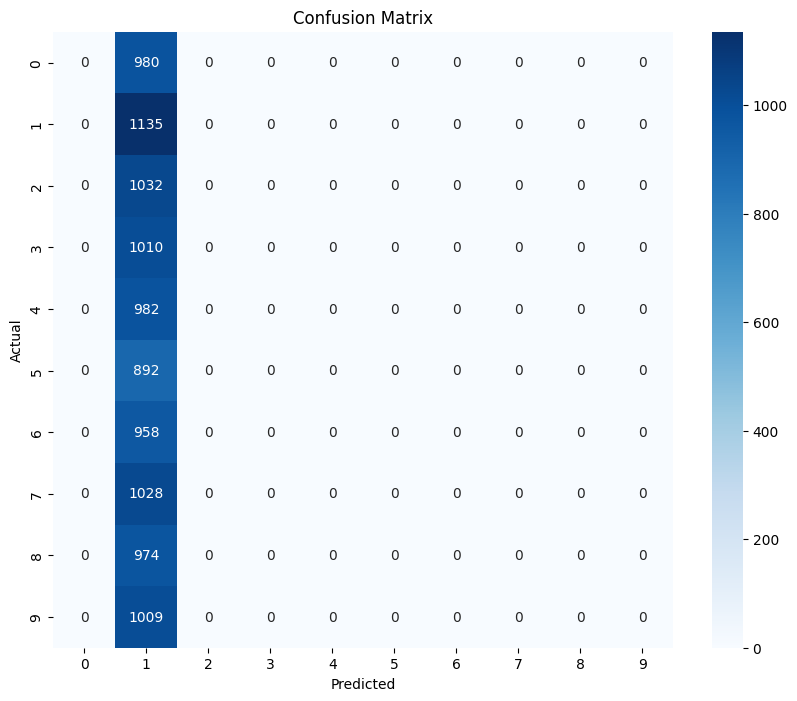

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# MNIST veri setini yükle
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# 1. Veri Ön İşleme
# Normalize et (Min-Max Scaler)
scaler = MinMaxScaler()
x_train = x_train.reshape(-1, 28 * 28).astype('float32')  # Flatten
x_test = x_test.reshape(-1, 28 * 28).astype('float32')
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Label'ları one-hot encode yap
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Train-validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# 2. Model Tasarımı
from tensorflow.keras.layers import Layer, Dense, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma=0.1, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.constant(gamma)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[-1]),
                                       initializer='uniform',
                                       trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # L2 distance
        diff = K.expand_dims(inputs, axis=1) - self.centers
        l2 = K.sum(K.square(diff), axis=-1)
        return K.exp(-self.gamma * l2)

# RBF tabanlı model
def create_model(units, gamma):
    inputs = Input(shape=(28 * 28,))
    rbf = RBFLayer(units=units, gamma=gamma)(inputs)
    dense = Dense(128, activation='relu')(rbf)
    outputs = Dense(10, activation='softmax')(dense)
    model = Model(inputs, outputs)
    return model

# 3. Hiperparametre Optimizasyonu
!pip install keras-tuner
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch

def build_model(hp):
    units = hp.Int('units', min_value=10, max_value=50, step=10)
    gamma = hp.Float('gamma', min_value=0.1, max_value=1.0, step=0.1)
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])


    model = create_model(units=units, gamma=gamma)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

'''def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(28 * 28,)))

    # Gizli katmanlar için nöron sayısı ve aktivasyon fonksiyonu optimize ediliyor
    for i in range(hp.Int('num_layers', 1, 3)):  # 1 ile 3 arasında katman sayısı
        model.add(tf.keras.layers.Dense(
            units=hp.Int('units', min_value=32, max_value=128, step=32),
            activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
        ))
        # Dropout oranı
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))

    # Çıkış katmanı
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    # Optimizasyon algoritması ve öğrenme oranı
    optimizer = hp.Choice('optimizer', values=['adam', 'sgd', 'rmsprop'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')

    model.compile(optimizer=tf.keras.optimizers.get(optimizer)(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model '''

# Random Search ile hiperparametre optimizasyonu


tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='mnist_rbf_tuning',
    project_name='rbf_mnist'
)

tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# En iyi hiperparametreleri al
best_hps = tuner.get_best_hyperparameters(1)[0]
print(f"Best Hyperparameters: Units={best_hps.get('units')}, Gamma={best_hps.get('gamma')}, Learning Rate={best_hps.get('learning_rate')}")

# 4. En iyi model ile eğitim
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

# 5. Test Değerlendirme
y_pred = best_model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Classification report
print(classification_report(y_test_labels, y_pred_labels))

# Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Model başarı ortalaması %10 larda seyrediyor. Oldukça başarısız bir model olduğunu söyleyebiliriz. Model sadece '1' rakamını tanımakta %20 doğruluk oranına sahip diğer sınıfları tahmin edememektedir. Hiperparametre tuning işlemi tekrar gözden geçirilmelidir.

# **Gaussian Process Regressor**

In [6]:
from __future__ import print_function
from sklearn.gaussian_process.kernels import PairwiseKernel
import keras
#from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.gaussian_process import GaussianProcessRegressor
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam, Nadam

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#                         PREPROCESSING DATA

# Change from matrix to array --> dimension 28x28 to array of dimention 784
x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)

# Change to float datatype
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Scale the data to lie between 0 to 1
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# one hot encoding
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)



# KMEANS to find centers

kmeans_model = KMeans(10)
kmeans_model.fit(x_train)
centers = kmeans_model.cluster_centers_
x = kmeans_model.predict(kmeans_model.cluster_centers_)
x = keras.utils.to_categorical(x, 10)


y_trainn= kmeans_model.predict(x_train)
y_trainn=keras.utils.to_categorical(y_trainn,10)
y_testt=kmeans_model.predict(x_test)
y_testt=keras.utils.to_categorical(y_testt, 10)


# RBF LAYER

kernel = PairwiseKernel(metric='polynomial')
rbf_model = GaussianProcessRegressor(kernel=kernel).fit(centers, x)

temp1 = rbf_model.predict(x_train)
temp2 = rbf_model.predict(x_test)


# PERCEPTRONS LAYERS
batch_size = 128
epochs = 10

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(10,)))
model.add(Dropout(0.2))



model.add(Dense(10, activation='softmax'))

model.summary()
nadam=keras.optimizers.Nadam(learning_rate = 0.0005)
model.compile(loss='categorical_crossentropy',
              optimizer=nadam,
              metrics=['accuracy','precision','recall','f1_score'])

# TRAINING THE MODEL
history = model.fit(temp1, y_trainn,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(temp2, y_testt))

# EVALUATE TRAINED MODEL
score = model.evaluate(temp2, y_testt, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Test precision:', score[2])
print('Test recall:', score[3])
print('Test F1_Score:', score[4])

60000 train samples
10000 test samples


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 512)                 │           5,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,762 (42.04 KB)

 Trainable params: 10,762 (42.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7936 - f1_score: 0.7746 - loss: 1.2712 - precision: 0.8981 - recall: 0.3026 - val_accuracy: 0.9436 - val_f1_score: 0.9408 - val_loss: 0.2626 - val_precision: 0.9704 - val_recall: 0.8612
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9505 - f1_score: 0.9495 - loss: 0.2261 - precision: 0.9760 - recall: 0.8877 - val_accuracy: 0.9628 - val_f1_score: 0.9605 - val_loss: 0.1578 - val_precision: 0.9780 - val_recall: 0.9325
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9640 - f1_score: 0.9630 - loss: 0.1484 - precision: 0.9786 - recall: 0.9359 - val_accuracy: 0.9690 - val_f1_score: 0.9675 - val_loss: 0.1225 - val_precision: 0.9796 - val_recall: 0.9496
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9672 - f1_score: 0.9663 - loss: 0.1152 - precision: 0.9790 - recall: 0.9505 - val_accuracy: 0.9751 - val_f1_score: 0.9735 - val_loss: 0.1037 - val_precision: 0.9839 - val_recall:

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


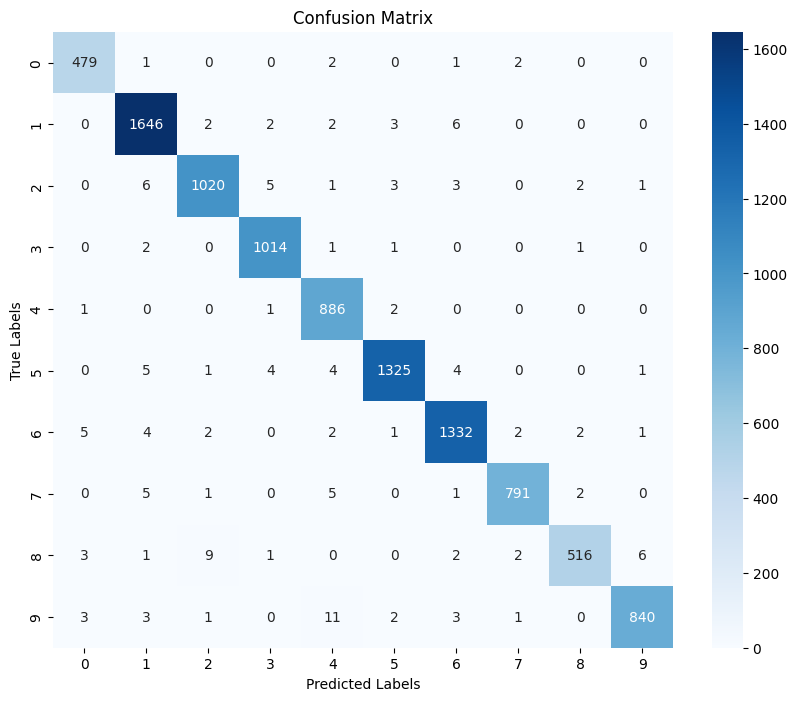

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       485
           1       0.98      0.99      0.99      1661
           2       0.98      0.98      0.98      1041
           3       0.99      1.00      0.99      1019
           4       0.97      1.00      0.98       890
           5       0.99      0.99      0.99      1344
           6       0.99      0.99      0.99      1351
           7       0.99      0.98      0.99       805
           8       0.99      0.96      0.97       540
           9       0.99      0.97      0.98       864

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Modelden tahmin edilen değerler
y_pred = model.predict(temp2)  # Test verilerinde tahminler
y_pred_classes = np.argmax(y_pred, axis=1)  # Tahmin edilen sınıflar
y_true = np.argmax(y_testt, axis=1)  # Gerçek sınıflar

# Confusion Matrix'i oluştur
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Confusion Matrix'i görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


Model oldukça iyi performans gösteriyor ve test setinde %98 doğruluk oranı ile başarılı bir sınıflandırıcı olduğunu kanıtlıyor.
Hatalar çoğunlukla sınıf 8 ve sınıf 9'da yoğunlaşmış. Bu sınıflar üzerinde odaklanılarak (örneğin, daha fazla veri toplama, veri artırma teknikleri ya da hiperparametre optimizasyonu) performans daha da iyileştirilebilir.